### This notebook is to be used for testing and research on implementation of the TimesFM model. The actual production code is exclusively placed in .py files

In [1]:
import pandas as pd
import requests as r
from datetime import *     
import numpy as np
import os
import sys

In [2]:
sys.path.append(os.path.abspath('..'))

In [3]:
from data_utils.DataLoader import DataLoader

/opt/anaconda3/envs/SecooraVenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv('../data/test_data.csv')
df = df.iloc[:, [0, 1]].reset_index(drop=True)
df.columns = ["time", "result"]
df = df.drop(0, axis=0)
df

,time,result
1,2024-12-25T17:50:10.81222Z,-2.098
2,2024-12-25T17:55:19.800911Z,-2.064
3,2024-12-25T18:00:34.410826Z,-2.036
4,2024-12-25T18:05:43.303884Z,-2.017
5,2024-12-25T18:10:57.930353Z,-2.001
...,...,...
647,2024-12-28T05:20:38.736164Z,-2.928
648,2024-12-28T05:21:05.116032Z,-2.927
649,2024-12-28T05:21:32.13423Z,-2.925
650,2024-12-28T05:26:45.716006Z,-2.911


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [6]:
'''class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Last timestep output
        out = self.fc(out)
        return out'''

'class TimeSeriesDataset(Dataset):\n    def __init__(self, X, y):\n        self.X = torch.tensor(X, dtype=torch.float32)\n        self.y = torch.tensor(y, dtype=torch.float32)\n    \n    def __len__(self):\n        return len(self.X)\n    \n    def __getitem__(self, idx):\n        return self.X[idx], self.y[idx]\n\nclass LSTMModel(nn.Module):\n    def __init__(self, input_size, hidden_size, num_layers):\n        super(LSTMModel, self).__init__()\n        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)\n        self.fc = nn.Linear(hidden_size, 1)\n\n    def forward(self, x):\n        out, _ = self.lstm(x)\n        out = out[:, -1, :]  # Last timestep output\n        out = self.fc(out)\n        return out'

## TimesFM Testing

In [7]:
%pip install torch transformers accelerate

Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install --upgrade --pre transformers
%pip install git+https://github.com/huggingface/transformers.git

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/huggingface/transformers.git to /private/var/folders/4v/q1spznf91t36ybznjd9h0g480000gn/T/pip-req-build-a6hymiua
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /private/var/folders/4v/q1spznf91t36ybznjd9h0g480000gn/T/pip-req-build-a6hymiua
  Resolved https://github.com/huggingface/transformers.git to commit 8b73799500a69242d0afa73c1256bcaf7a3fff37
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [9]:
df_1 = pd.read_csv("../data/historical_data_2023.csv", parse_dates=["time"])
df_1 = df_1.sort_values("time").reset_index(drop=True)

df_2 = pd.read_csv("../data/historical_data_2024.csv", parse_dates=["time"])
df_2 = df_2.sort_values("time").reset_index(drop=True)

df_3 = pd.read_csv("../data/historical_data_2025.csv", parse_dates=["time"])
df_3 = df_3.sort_values("time").reset_index(drop=True)

In [10]:
df_3

,time,result
0,2025-01-01 00:02:24.356467+00:00,-1.577
1,2025-01-01 00:07:38.158235+00:00,-1.556
2,2025-01-01 00:12:46.919872+00:00,-1.536
3,2025-01-01 00:18:00.670455+00:00,-1.509
4,2025-01-01 00:23:09.592430+00:00,-1.483
...,...,...
17027,2025-04-29 23:29:25.395409+00:00,-1.906
17028,2025-04-29 23:34:33.795148+00:00,-1.839
17029,2025-04-29 23:39:42.345197+00:00,-1.776
17030,2025-04-29 23:49:59.391218+00:00,-1.657


In [11]:
import matplotlib.pyplot as plt

def plot_series(timestamps, values, title="Time Series", xlabel="Time", ylabel="Value", figsize=(10, 4)):
    plt.figure(figsize=figsize)
    plt.plot(timestamps, values, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


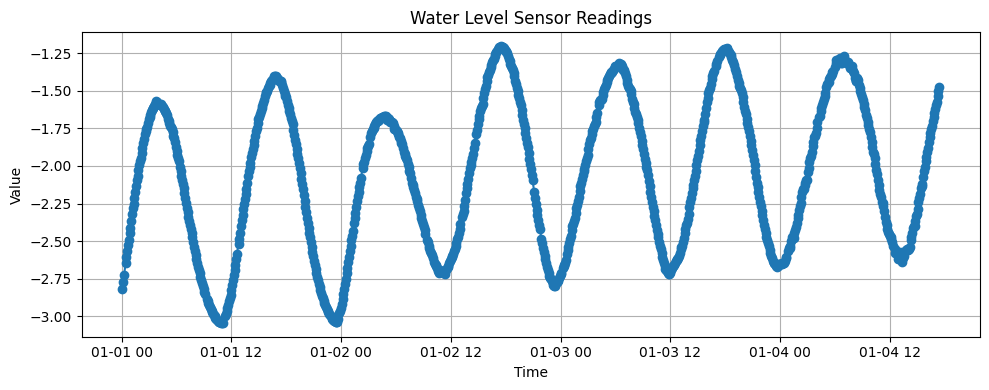

In [12]:
plot_series(df_2["time"][0:1000], df_2["result"][0:1000], title="Water Level Sensor Readings")

In [13]:
data = pd.concat([df_1, df_2, df_3], ignore_index=True)
data

,time,result
0,2023-03-14 17:17:24.631000+00:00,-0.516
1,2023-03-14 17:17:49.049000+00:00,-0.523
2,2023-03-14 17:18:14.053000+00:00,-0.533
3,2023-03-14 17:23:25.495000+00:00,-1.305
4,2023-03-14 17:28:33.261000+00:00,-1.290
...,...,...
146742,2025-04-29 23:29:25.395409+00:00,-1.906
146743,2025-04-29 23:34:33.795148+00:00,-1.839
146744,2025-04-29 23:39:42.345197+00:00,-1.776
146745,2025-04-29 23:49:59.391218+00:00,-1.657


In [14]:
first_match = data.loc[data["time"].astype(str).str.contains("2025-01-03")].iloc[0]
first_match

time      2025-01-03 00:02:47.326959+00:00
result                              -2.211
Name: 130254, dtype: object

In [15]:
data = data[0:130254]
data

,time,result
0,2023-03-14 17:17:24.631000+00:00,-0.516
1,2023-03-14 17:17:49.049000+00:00,-0.523
2,2023-03-14 17:18:14.053000+00:00,-0.533
3,2023-03-14 17:23:25.495000+00:00,-1.305
4,2023-03-14 17:28:33.261000+00:00,-1.290
...,...,...
130249,2025-01-02 23:36:43.524793+00:00,-2.497
130250,2025-01-02 23:41:55.893144+00:00,-2.440
130251,2025-01-02 23:47:04.485416+00:00,-2.379
130252,2025-01-02 23:52:18.788289+00:00,-2.321


In [16]:
from transformers import TimesFmModelForPrediction, Trainer, TrainingArguments
import pickle

In [17]:
class TimeSeriesDataset:
    def __init__(self, series: np.ndarray, context_len: int, horizon_len: int, freq: int):
        self.series = series
        self.context_len = context_len
        self.horizon_len = horizon_len
        self.freq = freq

    def get_latest_context_and_times(self):
        context = self.series[-self.context_len:]
        context_tensor = torch.tensor(context, dtype=torch.float32).unsqueeze(0)  # [1, context_len]
        past_times = torch.arange(self.context_len).unsqueeze(0)  # dummy time steps
        future_times = torch.arange(self.context_len, self.context_len + self.horizon_len).unsqueeze(0)
        return context_tensor, past_times, future_times

In [73]:
series = data["result"].to_numpy(dtype="float32")

# Configs
context_len = 1000
horizon_len = 40
freq = 0  # unknown/irregular

# Prepare input for model
context_vals = torch.tensor(series[-context_len:], dtype=torch.float32).unsqueeze(0)  # [1, context_len]

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pretrained TimesFM model
model = TimesFmModelForPrediction.from_pretrained("google/timesfm-2.0-500m-pytorch")
model.to(device)
model.eval()

# Run inference
with torch.no_grad():
    output = model(
        past_values=context_vals.to(device),  # [1, context_len]
        freq=torch.tensor([freq], dtype=torch.long).to(device),  # [1]
    )
    forecast = output.mean_predictions[0][:horizon_len].cpu().numpy()  # <- sliced to horizon_len
    print("Forecasted values:", forecast)

# Save forecast to .pkl file
save_dir = "model/timesfm_pretrained"
os.makedirs(save_dir, exist_ok=True)

forecast_path = os.path.join(save_dir, "forecast.pkl")
with open(forecast_path, "wb") as f:
    pickle.dump(forecast, f)

print(f"Forecast saved to {forecast_path}")

# Also save model (optional, for reuse)
model.save_pretrained(save_dir)
torch.save(model.state_dict(), os.path.join(save_dir, "model_state_dict.pt"))
print(f"Model saved to {save_dir}/")

Forecasted values: [-2.2349875 -2.1852858 -2.134122  -2.0862243 -2.0329509 -1.9801179
 -1.9320153 -1.8821563 -1.8421938 -1.8001012 -1.7562478 -1.7221771
 -1.6860055 -1.6424928 -1.602141  -1.5732975 -1.5438213 -1.5145434
 -1.491692  -1.4689149 -1.4438988 -1.4207795 -1.4040105 -1.3843334
 -1.3607249 -1.3372494 -1.3181123 -1.2998292 -1.2865468 -1.2641969
 -1.2477181 -1.2357624 -1.230873  -1.2253376 -1.2135278 -1.2117745
 -1.2100863 -1.2033403 -1.1990587 -1.1890748]
Forecast saved to model/timesfm_pretrained/forecast.pkl
Model saved to model/timesfm_pretrained/


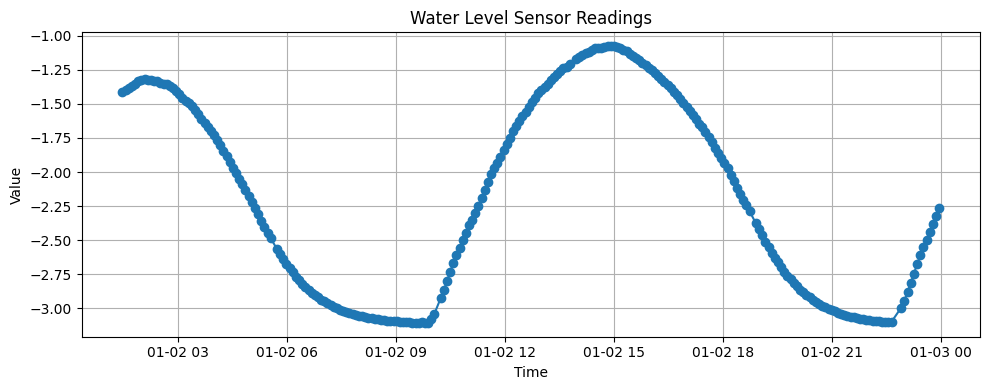

In [74]:
start = 130000
end = 130254
plot_series(data["time"][start : end], data["result"][start : end], title="Water Level Sensor Readings")

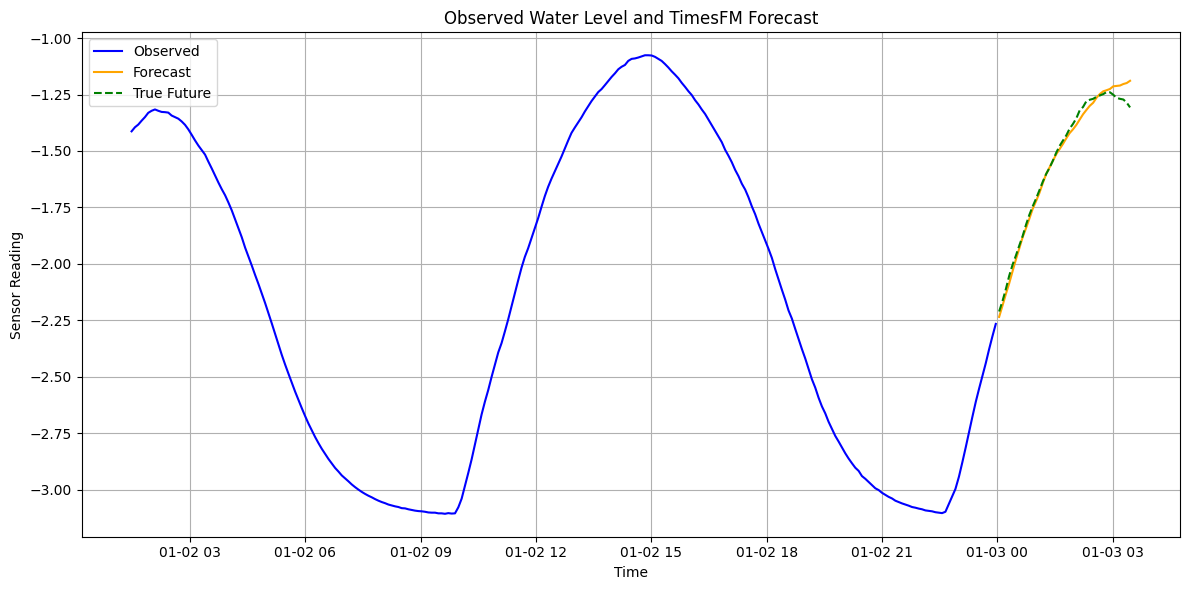

In [75]:
start = 130000
end = 130254
observed_times = data["time"][start:end].reset_index(drop=True)
observed_values = data["result"][start:end].reset_index(drop=True)

# Step 2: Assume forecast is stored in this variable (NumPy array)
# forecast = np.array([...])  # Already computed from TimesFM

# Step 3: Generate future timestamps at same frequency
# We'll assume constant interval based on last two timestamps
time_delta = observed_times.iloc[-1] - observed_times.iloc[-2]
forecast_times = [observed_times.iloc[-1] + (i + 1) * time_delta for i in range(len(forecast))]

# Step 4: Plot everything
plt.figure(figsize=(12, 6))
plt.plot(observed_times, observed_values, label="Observed", color="blue")
plt.plot(forecast_times, forecast, label="Forecast", color="orange")
plt.xlabel("Time")
plt.ylabel("Sensor Reading")
plt.title("Observed Water Level and TimesFM Forecast")
plt.grid(True)
plt.tight_layout()
#plt.show()

true_future_values = df_3["result"][539:539 + horizon_len].reset_index(drop=True)

# Align with the same forecast_times (assuming same frequency and meaning)
plt.plot(forecast_times[:len(true_future_values)], true_future_values, label="True Future", color="green", linestyle="dashed")
plt.legend()
plt.show()

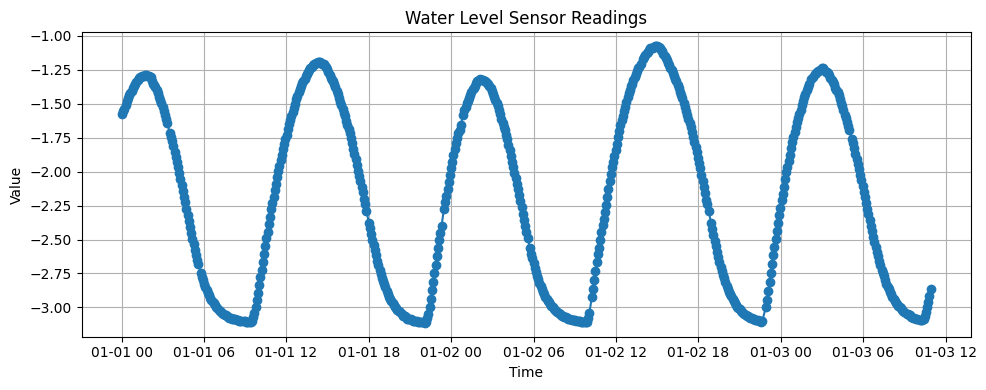

In [76]:
plot_series(df_3['time'][:539 + 120], df_3['result'][:539 + 120], title="Water Level Sensor Readings")